In [1]:
%matplotlib notebook

import pandas as pd               
import numpy as np                
import matplotlib                 
from matplotlib import pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns             
import sklearn                    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import scipy                      
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import collections
import requests
import platform
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
# remove the max column restriction for displaying on the screen
pd.options.display.max_columns=None
pd.set_option('display.max_rows', 600000)


In [3]:
online_ret = pd.read_csv("online_ret.txt", sep=";")

# remove blank from column names
online_ret.columns = online_ret.columns.str.replace(" ", "")

# remove blank from clumn
online_ret['sale_channel_standard'] = online_ret['sale_channel_standard'].str.strip()
online_ret['v_industry_name'] = online_ret['v_industry_name'].str.strip()

## Phân tích khả năng golive gian hàng KiotViet

Một gian hàng bán hàng online ở KiotViet ta sẽ xét theo 4 yếu tố:
* Gian hàng có kết nối với sàn TMĐT của KiotViet
* Gian hàng có phát sinh giao dịch online (Hóa đơn, đơn hàng)
* Gian hàng sử dụng FBPOS
* Gian hàng sử dụng myKiot

Sau đây ta sẽ phân tích chi tiết các gian hàng đang active của KiotViet dựa trên 4 yếu tố này

In [4]:
print("Số lượng gian hàng active: {}".format(len(np.unique(online_ret['retailer_key']))))
print("Số lượng gian hàng active kết nối sàn TMĐT qua KiotViet: {}".format(len(np.unique(online_ret[online_ret['connected_status']==1]['retailer_key']))))
print("Số lượng gian hàng phát sinh giao dịch online: {}".format(len(np.unique(online_ret[online_ret['sale_channel_standard']=='Online']['retailer_key']))))
print("Số lượng gian hàng sử dụng FBPOS: {}".format(len(np.unique(online_ret[online_ret['fbpos']==1]['retailer_key']))))
print("Số lượng gian hàng sử dụng myKiot: {}".format(len(np.unique(online_ret[online_ret['mykiot']==1]['retailer_key']))))
print("Số lượng gian hàng phát sinh giao dịch online hoặc sử dụng FBPOS hoặc myKiot hoặc kết nối sàn TMĐT: {}".format(len(np.unique(online_ret[(online_ret['sale_channel_standard']=='Online')| 
                                                                                                                                    (online_ret['connected_status']==1)| 
                                                                                                                                    (online_ret['fbpos']==1)| 
                                                                                                                                    (online_ret['mykiot']==1)]['retailer_key']))))

Số lượng gian hàng active: 108264
Số lượng gian hàng active kết nối sàn TMĐT qua KiotViet: 5854
Số lượng gian hàng phát sinh giao dịch online: 10689
Số lượng gian hàng sử dụng FBPOS: 2823
Số lượng gian hàng sử dụng myKiot: 8017
Số lượng gian hàng phát sinh giao dịch online hoặc sử dụng FBPOS hoặc myKiot hoặc kết nối sàn TMĐT: 18683


Số lượng các gian hàng online/active hiện tại chỉ chiếm khoảng 17%, khá thấp. Danh mục tiềm năng của ta sẽ gồm:
* Các gian hàng có dấu hiệu online (phát sinh giao dịch online, sử dụng FBPOS và myKiot) nhưng chưa kết nối sàn TMĐT, ta sẽ dựa vào tín hiệu active, khối lượng giao dịch để tìm ra tập khách hàng tiềm năng nhất trong danh sách này
* Các gian hàng không có dấu hiệu online nhưng có triển vọng go live, ta sẽ phân tích từ đặc điểm ngành để đi sâu vào các nhóm ngành này

## Phân tích khả năng golive theo ngành hàng

In [5]:
# Gán nhán tình trạng phát sinh giao dịch online của gian hàng
channel = online_ret.groupby('retailer_key')['sale_channel_standard'].apply(np.unique).apply(lambda x: x.sum()).reset_index()
def label_online(channel):
    if channel == 'Other':
        return 0
    elif channel == 'Online':
        return 1
    elif channel == 'OnlineOther':
        return 2
    elif channel == 'OfflineOther':
        return 3
    elif channel == 'OfflineOnlineOther':
        return 4
    else:
        return None

channel['online_status'] = channel['sale_channel_standard'].apply(label_online)
print('Số lượng gian hàng theo các sale channel:\n', channel['online_status'].value_counts())

Số lượng gian hàng theo các sale channel:
 0    97016
2     9931
4      716
3      559
1       42
Name: online_status, dtype: int64


Chủ yếu các gian hàng giao dịch qua các kênh khác (90%), các gian hàng có giao dịch online (1,2&4) chiếm khoảng 9.8%.

In [6]:
# merge với online_ret

online_ret = pd.merge(online_ret, channel[['retailer_key','online_status']],
                     how = 'left', on =['retailer_key','retailer_key'])

In [7]:
# Số lượng gian hàng theo tình trạng phát sinh giao dịch online theo từng ngành hàng
online_ind = online_ret.groupby(['v_industry_name','online_status'])['retailer_key'].nunique().reset_index()
online_ind = online_ind.pivot(index = 'v_industry_name', columns = 'online_status',
                             values = 'retailer_key').fillna(0).reset_index()
online_ind['total_ret'] = online_ind[0]+online_ind[1]+online_ind[2]+online_ind[3]+online_ind[4]
online_ind['online_per'] = round((online_ind[1]+online_ind[2]+online_ind[4])*100/online_ind['total_ret'],2)
online_ind.sort_values('total_ret', inplace = True)

# Số lượng gian hàng theo tình trạng kết nối sàn TMĐS KiotViet theo từng ngành hàng
connected_ind = online_ret.groupby(['v_industry_name','connected_status'])['retailer_key'].nunique().reset_index()
connected_ind = connected_ind.pivot(index='v_industry_name', columns ='connected_status',
                                    values = 'retailer_key').fillna(0).reset_index()
connected_ind['total_ret'] = connected_ind[0]+connected_ind[1]
connected_ind['connected_per'] = round(connected_ind[1]*100/connected_ind['total_ret'],2)
connected_ind.sort_values('total_ret', inplace = True)

# Số lượng gian hàng theo sử dụng FBPOS theo từng ngành hàng
FBPOS_ind = online_ret.groupby(['v_industry_name','fbpos'])['retailer_key'].nunique().reset_index()
FBPOS_ind = FBPOS_ind.pivot(index='v_industry_name', columns ='fbpos',
                                    values = 'retailer_key').fillna(0).reset_index()
FBPOS_ind['total_ret'] = FBPOS_ind[0]+FBPOS_ind[1]
FBPOS_ind['FBPOS_per'] = round(FBPOS_ind[1]*100/FBPOS_ind['total_ret'],2)
FBPOS_ind.sort_values('total_ret', inplace = True)

# Số lượng gian hàng theo sử dụng myKiot theo từng ngành hàng
mykiot_ind = online_ret.groupby(['v_industry_name','mykiot'])['retailer_key'].nunique().reset_index()
mykiot_ind = mykiot_ind.pivot(index='v_industry_name', columns ='mykiot',
                                    values = 'retailer_key').fillna(0).reset_index()
mykiot_ind['total_ret'] = mykiot_ind[0]+mykiot_ind[1]
mykiot_ind['mykiot_per'] = round(mykiot_ind[1]*100/mykiot_ind['total_ret'],2)
mykiot_ind.sort_values('total_ret', inplace = True)

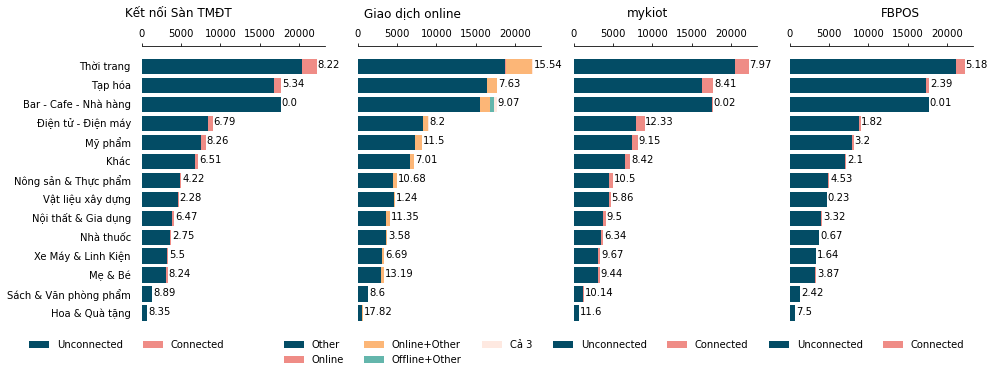

In [13]:
# Tạo Tornado chart
channels = range(0,5)
connected = range(0,2)
colors1 = ['#034C65', '#EF8C86', '#FCB677', '#64B6AC', '#FEE9E1']
colors2 = ['#034C65', '#EF8C86']
labels1 = ['Other', 'Online', 'Online+Other', 'Offline+Other', 'Cả 3']
labels2 = ['Unconnected', 'Connected']

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_axes([0.13, 0.09, 0.17, 0.8])
ax2 = fig.add_axes([0.33, 0.09, 0.17, 0.8])
ax3 = fig.add_axes([0.53, 0.09, 0.17, 0.8])
ax4 = fig.add_axes([0.73, 0.09, 0.17, 0.8])

left = len(connected_ind) * [0]
for idx, connect in enumerate(connected):
    ax1.barh(connected_ind.v_industry_name, connected_ind[connect], left = left, color=colors2[idx], align='center')
    left = left + connected_ind[connect]
ax1.legend(labels2, bbox_to_anchor=([0.5,0.01,0,0]), ncol=2, frameon=False)

left = len(online_ind) * [0]
for idx, channel in enumerate(channels):
    ax2.barh(online_ind.v_industry_name, online_ind[channel], left = left, color=colors1[idx], align = 'center')
    left = left + online_ind[channel]
ax2.legend(labels1, bbox_to_anchor=([1.0,0.01,0,0]), ncol=3, frameon=False)
# ax2.set_xlim(0, 25000)

left = len(mykiot_ind) * [0]
for idx, connect in enumerate(connected):
    ax3.barh(mykiot_ind.v_industry_name, mykiot_ind[connect], left = left, color=colors2[idx], align = 'center')
    left = left + mykiot_ind[connect]
ax3.legend(labels2, bbox_to_anchor=([1.0,0.01,0,0]), ncol=2, frameon=False)

left = len(FBPOS_ind) * [0]
for idx, connect in enumerate(connected):
    ax4.barh(FBPOS_ind.v_industry_name, FBPOS_ind[connect], left = left, color=colors2[idx], align = 'center')
    left = left + FBPOS_ind[connect]
ax4.legend(labels2, bbox_to_anchor=([1.0,0.01,0,0]), ncol=2, frameon=False)

# Set titles
ax1.set_title('Kết nối Sàn TMĐT', x=0.2,y=1.08,fontsize=12)
ax2.set_title('Giao dịch online', x=0.3,y=1.08,fontsize=12)
ax3.set_title('mykiot', x=0.4,y=1.08,fontsize=12)
ax4.set_title('FBPOS', x=0.6,y=1.08,fontsize=12)

# hide plot spines
for ax in (ax1,ax2,ax3,ax4):
    ax.xaxis.set_ticks_position('top')
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# center the industry label in the plot
transform = transforms.blended_transform_factory(fig.transFigure, ax1.transData)

for i, label in enumerate(connected_ind.v_industry_name):
    ax1.text(0.12,i,label,ha='right', va='center', transform=transform)
    
# add text

for p, i, j in zip(ax1.patches, connected_ind.connected_per, connected_ind.total_ret):
    ax1.annotate(i, 
                 xy = (j+100, p.get_y()+0.35),
                 xytext = (0,0),
                 textcoords = 'offset points', ha = 'left',
                 size =10)
    
for p, i, j in zip(ax2.patches, online_ind.online_per, online_ind.total_ret):
    ax2.annotate(i, 
                 xy = (j+100, p.get_y()+0.35),
                 xytext = (0,0),
                 textcoords = 'offset points', ha = 'left',
                 size =10)

for p, i, j in zip(ax3.patches, mykiot_ind.mykiot_per, mykiot_ind.total_ret):
    ax3.annotate(i, 
                 xy = (j+100, p.get_y()+0.35),
                 xytext = (0,0),
                 textcoords = 'offset points', ha = 'left',
                 size =10)    
for p, i, j in zip(ax4.patches, FBPOS_ind.FBPOS_per, FBPOS_ind.total_ret):
    ax4.annotate(i, 
                 xy = (j+100, p.get_y()+0.35),
                 xytext = (0,0),
                 textcoords = 'offset points', ha = 'left',
                 size =10)     
plt.show()

Tỷ lệ gian hàng online ở từng ngành hàng khác nhau thể hiện đúng bản chất từng ngàng hàng:
* Ngành thời trang có số lượng gian hàng nhiều nhất ở KiotViet, đi kèm với tỷ lệ online cao (Kết nối sàn TMĐT, giao dịch online, mykiot,FBPOS) -> Nhóm ngành có nhiều tiềm năng để go live nhất
* Hoa & quà tặngm Sách & VPP, Mẹ & Bé mặc dù có tỷ lệ online cao nhưng số lượng gian hàng thấp -> có tiềm năng nhưng số lượng không nhiều
* Một số ngành hàng có nhiều tiềm năng khác như mỹ phẩm, Nông sản & Thực phẩm, Điện tử-điện máy
* FnB cũng là 1 ngành có tỷ lệ gian hàng giao dịch online khá nhiều tuy nhiên hiện nay KiotViet chưa có kết nối lên các sàn TMĐT online bán đồ FnB như Foody, Now etc nên số lượng kết nối hiện là 0. 

## Phân tích ảnh hưởng của các feature đến gian hàng online

Text(0.5, 1.0, 'Correlation giữa gian hàng online và Score theo từng sale channel')

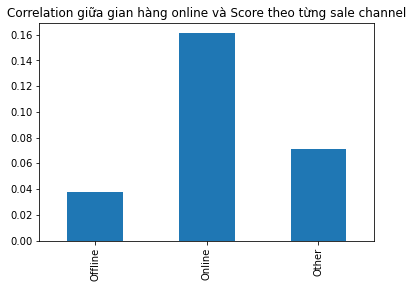

In [9]:
%matplotlib inline
# Tính hệ số score dựa trên số lượng invoice và giá trị invoice của từng gian hàng
inv_ret = online_ret.groupby(['retailer_key','sale_channel_standard'])['amount'].sum().reset_index()
amount_ret = online_ret.groupby(['retailer_key','sale_channel_standard'])['no_key'].sum().reset_index()
inv_amount = pd.merge(inv_ret, amount_ret, how='left', left_on=['retailer_key','sale_channel_standard'], right_on=['retailer_key','sale_channel_standard'])
inv_amount['scaled_amount'] = (inv_amount['amount'] - inv_amount['amount'].min())/(inv_amount['amount'].max() - inv_amount['amount'].min())
inv_amount['scaled_inv'] = (inv_amount['no_key'] - inv_amount['no_key'].min())/(inv_amount['no_key'].max() - inv_amount['no_key'].min())
inv_amount['score'] = (0.5*inv_amount['scaled_amount'] + 0.5*inv_amount['scaled_inv'])*100

# Gian hàng online nếu có 1 trong các dấu hiệu online 
online_ret['online'] = online_ret.apply(lambda row:1 if any(x in [1,2,4] for x in (row['fbpos'],row['mykiot'],row['connected_status'],row['online_status']))
                                        else 0, axis=1)
# Lấy tình trạng kết nối sàn TMĐT
inv_amount = inv_amount.pivot(index='retailer_key', columns='sale_channel_standard', values='score').fillna(0).reset_index()
inv_amount = pd.merge(inv_amount, online_ret[['retailer_key','online']].drop_duplicates(), how = 'left',
                   on = (['retailer_key','retailer_key']))
# tạo box plot correlation
sc = ['Offline','Online','Other']
inv_amount.corr()['online'][sc].plot.bar()
plt.title("Correlation giữa gian hàng online và Score theo từng sale channel")

Tình trạng kết nối gian hàng với sàn TMĐT có tương quan nhiều nhất với score của gian hàng phát sinh giao dịch online tuy nhiên chỉ số corr chỉ khoảng 0.16, khá thấp. Điều này phản ảnh ở việc có nhiều gian hàng phát sinh giao dịch online nhưng không kết nối và số lượng giao dịch online không nhiều. Nên nếu feature này làm yếu tố chính để lấy những gian hàng có tiềm năng go live thì sẽ không chính xác lắm.

Tiếp theo ta sẽ tìm tương quan giữa các gian hàng online và số lượng sản phẩm

In [25]:
product = online_ret[['retailer_key','v_industry_name','product','online']].drop_duplicates()
print('Correlation giữa gian hàng online và số lượng sản phẩm: ',  product.corr()['online']['product'])

Correlation giữa gian hàng online và số lượng sản phẩm:  0.07770866678404377


Như vậy việc các gian hàng online cũng không có nhiều tương quan với số lượng sản phẩm các gian hàng. Nên thay vì đi tìm các gian hàng online theo tìm kiếm các feature ta sẽ giải quyết bằng cách tìm ra các top sản phẩm của các gian hàng online và tìm ra sự tương tự dựa trên các gian hàng còn lại để tìm kiếm các gian hàng tiềm năng.

## Phân tích top sản phẩm các gian hàng online
Như phân tích ở trên Thời trang, Mỹ phẩm và Điện tử điện máy đang là những nhóm ngành có tỷ lệ online tốt nhất. Nên từ những nhóm ngành này ta sẽ tìm ra những gian hàng có tiềm năng online dựa trên độ tương tự về sản phẩm.